<a href="https://colab.research.google.com/github/krazyguy/fcc_predict_health_costs_with_regression/blob/main/fcc_predict_health_costs_with_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2025-01-11 22:27:13--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  49.09K  --.-KB/s    in 0.01s   

2025-01-11 22:27:13 (4.56 MB/s) - ‘insurance.csv’ saved [50264/50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [5]:

# Assuming 'dataset' is already loaded as in the previous code

def find_outliers_iqr(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers

# Find outliers for age
outliers_age = find_outliers_iqr(dataset['age'])
print("Outliers in age:", outliers_age)


# Find outliers for bmi
outliers_bmi = find_outliers_iqr(dataset['bmi'])
print("\nOutliers in bmi:", outliers_bmi)

# Find outliers for children
outliers_children = find_outliers_iqr(dataset['children'])
print("\nOutliers in children:", outliers_children)


# Find outliers for expenses
outliers_expenses = find_outliers_iqr(dataset['expenses'])
print("\nOutliers in expenses:", outliers_expenses)

Outliers in age: Series([], Name: age, dtype: int64)

Outliers in bmi: 116     49.1
286     48.1
401     47.5
543     47.4
847     50.4
860     47.6
1047    52.6
1088    47.7
1317    53.1
Name: bmi, dtype: float64

Outliers in children: Series([], Name: children, dtype: int64)

Outliers in expenses: 14      39611.76
19      36837.47
23      37701.88
29      38711.00
30      35585.58
          ...   
1300    62592.87
1301    46718.16
1303    37829.72
1313    36397.58
1323    43896.38
Name: expenses, Length: 139, dtype: float64


In [14]:
dataset['sex'].describe()

,sex
count,1338
unique,2
top,male
freq,676


In [16]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
dataset['sex'] = encoder.fit_transform(dataset['sex'])


In [19]:
dataset['smoker'].describe()

,smoker
count,1338
unique,2
top,no
freq,1064


In [21]:
dataset['smoker'] = encoder.fit_transform(dataset['smoker'])


In [22]:
dataset['smoker'].describe()

,smoker
count,1338.000000
mean,0.204783
std,0.403694
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [23]:
dataset['region'].describe()

,region
count,1338
unique,4
top,southeast
freq,364


In [25]:
dataset['region'] = encoder.fit_transform(dataset['region'])


In [26]:
dataset['region'].describe()

,region
count,1338.000000
mean,1.515695
std,1.104885
min,0.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,3.000000


In [28]:
dataset.corr()

,age,sex,bmi,children,smoker,region,expenses
age,1.000000,-0.020856,0.109341,0.042469,-0.025019,0.002127,0.299008
sex,-0.020856,1.000000,0.046380,0.017163,0.076185,0.004588,0.057292
bmi,0.109341,0.046380,1.000000,0.012645,0.003968,0.157439,0.198576
children,0.042469,0.017163,0.012645,1.000000,0.007673,0.016569,0.067998
smoker,-0.025019,0.076185,0.003968,0.007673,1.000000,-0.002181,0.787251
region,0.002127,0.004588,0.157439,0.016569,-0.002181,1.000000,-0.006208
expenses,0.299008,0.057292,0.198576,0.067998,0.787251,-0.006208,1.000000


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split features and target
X = dataset.drop(columns=['expenses'])  # Features
y = dataset['expenses']  # Target

# Scale numerical features
numerical_features = ['age', 'bmi', 'children']  # Adjust based on your dataset
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
test_dataset = X_test
test_labels = y_test

In [45]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
model = keras.Sequential()
model.add(layers.Dense(128, input_dim=X_train.shape[1], activation='relu'))  # More units
model.add(layers.Dense(64, activation='relu'))  # Another hidden layer
model.add(layers.Dense(1, activation='linear'))  # Output layer # Single layer, linear output
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae', 'mse'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [48]:
# Train the Model
model.fit(X_train, y_train, epochs=200, batch_size=44, verbose=1)


Epoch 1/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35281140.0000 - mae: 4061.5081 - mse: 35281140.0000 
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38412320.0000 - mae: 4199.5474 - mse: 38412320.0000 
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34089808.0000 - mae: 3984.7532 - mse: 34089808.0000 
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34020116.0000 - mae: 3891.1931 - mse: 34020116.0000 
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34526364.0000 - mae: 3988.0164 - mse: 34526364.0000 
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34298328.0000 - mae: 4004.3647 - mse: 34298328.0000 
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34602300.0000 - mae: 3957.5894 - mse: 34602300.0000 
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34195048.0000 - mae: 3951.3599 - mse: 34195048.0000 
Epoch 9/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33768984.0000 - mae: 3940.6746 - mse: 3376898

9/9 - 0s - 4ms/step - loss: 24259084.0000 - mae: 3047.9944 - mse: 24259084.0000
Testing set Mean Abs Error: 3047.99 expenses
You passed the challenge. Great job!
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


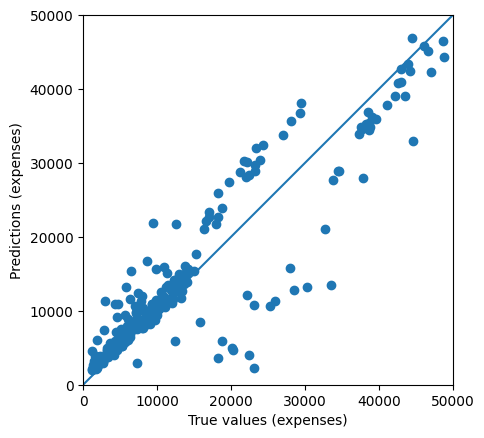

In [49]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
